# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

# Exploratory data analysis

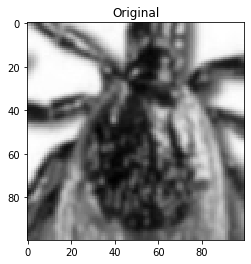

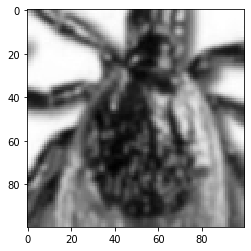

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [10]:
from debruiteur.postprocessing.postprocessor import *
img = cv2.imread('C:\\Users\\Romain\\Desktop\\ProjetHeArc\\ledebruiteur\\noised_images\\img66_GaussianBlurNoise.jpg', cv2.IMREAD_GRAYSCALE)
plt.title("Original")
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

mean = fft_filter(img,5)
plt.imshow(mean, cmap=plt.cm.gray)
plt.show()

In [1]:
%matplotlib inline

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.plots.plots import plot_im_grid_from_list, plot_im_grid_from_df, plot_result_comparison
from debruiteur.preprocessing.preprocessor import *
from debruiteur.noise.noise import *
from debruiteur.utils.utils import load_model, split_train_val_df

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import metrics

Using TensorFlow backend.


## Configurations

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=10),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(freq=0.3),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
    AveragingBlurNoise(),
    GaussianBlurNoise(),
    MedianBlurNoise()
]

## Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

## Noise

plot_im_grid_from_df(df, noise, rows, columns, figsize)

Parameters :
* df : dataframe, with first column containing image's path
* noise : Sublclass of Noise
* rows : Number of rows in image grid
* columns : Number of columns in image grid
* figsize : Tuple, shape of subfigure

### None

In [ ]:
plot_im_grid_from_df(df_resized)

### Gaussian

Parameters :
* mean
* std

In [ ]:
mu, sigma = 0, 10
plot_im_grid_from_df(df_resized, GaussianNoise(mean=mu, std=sigma))

### Poisson

No parameters

In [ ]:
plot_im_grid_from_df(df_resized, PoissonNoise())

### Uniform

Parameters :
* ampltitude : in ]0; 255[

In [ ]:
plot_im_grid_from_df(df_resized, UniformNoise(100))

### Salt and pepper noise

Parameters :
* p : probability in ]0;1[

In [ ]:
plot_im_grid_from_df(df_resized, SaltPepperNoise(0.3))

### Squared mask

Parameters :
* mask_shape : tuple, (width, height)
* target_freq : frequence in ]0; 1[

In [ ]:
plot_im_grid_from_df(df_resized, SquareMaskNoise(mask_shape=(10, 10), freq=0.1))

### Speckle

No parameters

In [ ]:
plot_im_grid_from_df(df_resized, SpeckleNoise())

## Blur

### Averaging Blur

Parameters :

* kernel : tuple, kernel shape

In [ ]:
plot_im_grid_from_df(df_resized, AveragingBlurNoise())

### Gaussian Blur

Parameters :

* kernel : tuple, kernel shape

In [ ]:
plot_im_grid_from_df(df_resized, GaussianBlurNoise())

### Median Blur

* ksize : int, array's length

In [ ]:
plot_im_grid_from_df(df_resized, MedianBlurNoise())

## Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \dot \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

In [ ]:
path = df_noised.iloc[0, 0]
orignal_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

images = [orignal_img]

df_error = pd.DataFrame({"Noise": [], "MSE": [], "NRMSE": [], "PSNR": [], "SSIM": []})

for noise in noise_class_list:
    noised_img = noise.add(orignal_img)
    images.append(noised_img)
    
    noise_name = noise.__class__.__name__
    mse = metrics.mean_squared_error(orignal_img, noised_img)
    nrmse = metrics.normalized_root_mse(orignal_img, noised_img)
    psnr = metrics.peak_signal_noise_ratio(orignal_img, noised_img)
    ssim = metrics.structural_similarity(orignal_img, noised_img, multichannel=True)
    
    df_error = df_error.append({"Noise": noise_name, "MSE": mse, "NRMSE": nrmse, "PSNR": psnr, "SSIM": ssim}, ignore_index=True)
    
plot_im_grid_from_list(images, 5, 2)
df_error.head(len(noise_class_list))

## Models

### Convolutional autoencoder

In [ ]:
df_train, df_val = split_train_val_df(df_noised)

In [ ]:
ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")

In [ ]:
val_gen = DataGenerator(df_val)
plot_result_comparison(ae_model, val_gen)

In [ ]:
train_gen = DataGenerator(df_train)
plot_result_comparison(ae_model, train_gen)

In [ ]:
del ae_model
del train_gen
del val_gen

### Dense autoencoder

In [ ]:
ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")

In [ ]:
val_gen = DataGenerator(df_val, img_shape=(10000, ))
plot_result_comparison(ae_model, val_gen, reshape=(100, 100))

In [ ]:
train_gen = DataGenerator(df_train, img_shape=(10000, ))
plot_result_comparison(ae_model, train_gen, reshape=(100, 100))

In [ ]:
del ae_model
del train_gen
del val_gen